<a href="https://colab.research.google.com/github/BrunoTrinitario/IA2024-TP/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math as ma
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.initializers import glorot_uniform
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation, Input, concatenate
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import optimizers
from keras.callbacks import History

In [ ]:
def generateData(data_path):
  df=pd.read_csv(data_path)
  anios = df.iloc[:, 0].tolist()
  temperaturas = df.iloc[:, 1].tolist()
  data=df.iloc[:, 2:]
  temperaturas=np.array(temperaturas)
  data=np.array(data)
  return anios,temperaturas,data

def normData(data):
  min=np.min(data)
  max=np.max(data)
  return (data-min)/(max-min)


In [ ]:
def modelo(data):
  model = Sequential()
  model.add(LSTM(128, return_sequences= True, input_shape=(1, data.shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(128, return_sequences= False))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation= 'linear'))
  model.compile(optimizer=optimizers.Adam(), loss='mse', metrics=['accuracy'])
  return model

In [ ]:
def entrenar_modelo(model,epocas,x,y,testx=0,testy=0):
  scores=list()
  histories=list()
  history=model.fit(x, y, epochs=epocas, batch_size=32, verbose=1)
  #_, acc = model.evaluate(testx, testy, verbose=1)
  #print('> %.3f' % (acc * 100.0))
  #scores.append(acc)
  #histories.append(history)
  #return scores, histories, model

In [103]:
def graphYVT(x,y,type):
  plt.plot(x, y, label=type, color=np.random.rand(3,), linestyle='-', linewidth=2)
  plt.title('Anio VS. Temp')
  plt.xlabel('Anio')
  plt.legend()
  plt.ylabel('Temperatura')



In [106]:
anios,temperaturas,trainData=generateData('./trainData.csv')
trainData=normData(trainData)
trainData=np.expand_dims(trainData,axis=1)
model=modelo(trainData)
entrenar_modelo(model,50,trainData,temperaturas,testx=0,testy=0)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.0000e+00 - loss: 501.1555
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 500.7721 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 497.8527
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 499.0872 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0000e+00 - loss: 495.1418 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 493.4988 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 491.2610
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: 490.2977 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 488.5338 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 484.5423
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: 479.9996
Epoch 12/50
2/2 ━━━━━━━━

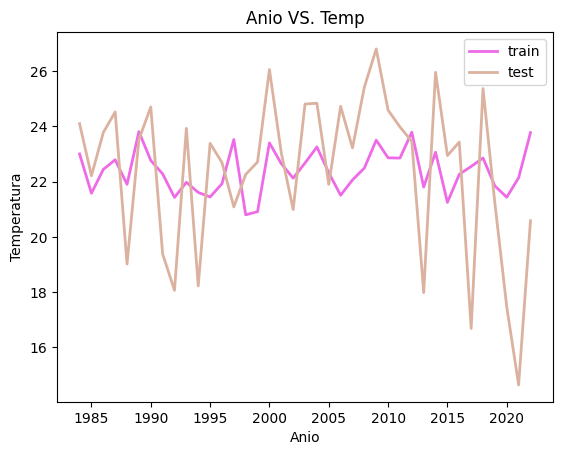

In [111]:
aux1,testTarget,testData=generateData('./testData.csv')
testData=normData(testData)
testData=np.expand_dims(testData,axis=1)
graphYVT(anios,temperaturas,'train')
graphYVT(aux1,testTarget,'test')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2.8919802325032546
(39, 1, 28)
(39, 1)
